# **Линейный дискриминантный анализ**
Линейный дискриминантный анализ (Linear Discriminant Analysis или LDA) — алгоритм классификации и понижения размерности, позволяющий производить разделение классов наилучшим образом. Основная идея LDA заключается в предположении о многомерном нормальном распределении признаков внутри классов и поиске их линейного преобразования, которое максимизирует межклассовую дисперсию и минимизирует внутриклассовую. Другими словами, объекты разных классов должны иметь нормальное распределение и располагаться как можно дальше друг от друга, а одного класса — как можно ближе.

Не смотря на наличие логистической регрессии, в ряде случаев LDA может быть более предпочтительным вариантом по нескольким причинам:
- поскольку LDA основан на моделировании распределения данных в каждом классе, ему требуется меньше параметров для оценки, что уменьшает склонность к переобучению;
- при большом количестве классов и их хорошем линейном разделении является более стабильным и эффективным;
- может быть использован для понижения размерности без применения дополнительных методов.

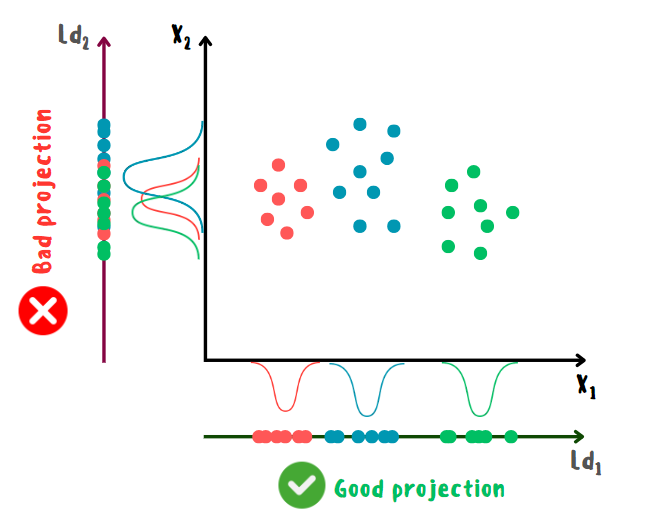

### **Принцип работы LDA**
Алгоритм строится следующим образом:
- 1) изначально для всех классов рассчитываются априорные вероятности и средние значения признаков;
- 2) на основе полученных значений рассчитываются (ковариационные) матрицы разброса между классами и внутри классов;
- 3) далее находятся собственные вектора и значения для линейного дискриминанта Фишера, который определяется отношением матриц из шага 2;
- 4) собственные вектора сортируются в порядке убывания в соответствии с собственными значениями и называются *дискриминантными векторами*, с помощью которых рассчитываются веса модели;
- 5) на основе полученных весов и априорных вероятностей рассчитывается вектор смещения;
- 6) новое пространство признаков меньшей размерности представляет из себя линейную комбинацию исходных признаков и дискриминантных векторов и называется *дискриминантным подпространством*;
- 7) спрогнозированные классы являются максимальной оценкой линейной комбинации тестовой выборки и весов + смещение.

**Формулы для расчётов**

$\mu_k = \frac{1}{n_k} \sum \limits_{i \in C_k} x_i \ - \ $ mean features  by class

$\mu = \frac{1}{n} \sum \limits_{i=1}^n x_i \ - \ $ mean features

$S_W = \sum \limits_{k=1}^K \sum \limits_{i \in C_k} (x_i - \mu_k)^T (x_i - \mu_k) \ - \ $ within-class covariance matrix

$S_B = \sum \limits_{k=1}^K \pi_k (\mu_k - \mu)^T (\mu_k - \mu) \ - \ $ between-class covariance matrix

$S_W^{-1} S_B v = \lambda v$

$w = \mu_k d_v d_v^T \ - \ $ weights

$b = \log \pi_k - \frac{1}{2} diag(\mu_k w^T) \ - \ $ bias

$\delta(x) = argmax(wx + b) \ \ by \ \ class \ - \ $ prediction

$\lambda - eigenvalues, \ \ v - eigenvectors$

$\pi_k \ - \ $ a prior probability of a class k

$d_v\ - \ $ discriminant vectors

### **Более продвинутые техники**
Помимо решения через нахождение собственных векторов, существуют также и другие подходы:
- использование сингулярного разложения, которое лучше подходит для данных с большим количеством признаков так как не вычисляется ковариационная матрица;
- решение методом наименьших квадратов, основанное на минимизации среднеквадратичной суммы отклонений по классам.

Помимо классического LDA, ещё существуют модификации на его основе, способные значительно не только улучшить качество модели, но и увеличить количество задач, в которых его можно применить. Наиболее популярными модификациями являются следующие:

- **Квадратичный дискриминантный анализ (QDA)** — это обобщение LDA, позволяющее каждому классу иметь собственную ковариационную матрицу. Это делает границу решения нелинейной и более гибкой, но также требует больше параметров для оценки.

- **Гибкий дискриминантный анализ (FDA)** — метод, который использует сглаживающие сплайны для построения нелинейных комбинаций признаков. Он может лучше аппроксимировать сложные зависимости между признаками и классами, но также может быть подвержен переобучению.

- **Ядерный дискриминантный анализ (KDA)** — метод отображения данных в пространстве более высокой размерности с использованием ядерного трюка (его суть объяснена в алгоритме SVM), где улучшается их линейная разделимость. Он также может улавливать сложные нелинейные зависимости, но требует выбора подходящего ядра и его параметров.

Стоит также отметить, что в LDA и его модификациях поддерживается регуляризация через степень сжатия ковариационной матрицы, которая регулируется с помощью параметра shrinkage (0 — отсутствие сжатия, 1 — полное сжатие). Сжатие ковариационной матрицы подразумевает увеличение её диагональных элементов и уменьшение внедиагональных. Такой подход добавляет штраф к модели за большие значения её параметров, что в целом повышает устойчивость и снижает риск переобучения. Также можно установить значение "shrinkage=auto", которое автоматически определяет оптимальный уровень сжатия с помощью леммы Ледуа-Вольфа.

### **Реализация на Python с нуля**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import eigh as sp_eigh
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.plotting import plot_decision_regions

In [ ]:
class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X, y):
        n_samples, n_features = X.shape
        classes, cls_counts = np.unique(y, return_counts=True)
        priors = cls_counts / n_samples

        X_cls_mean = np.array([X[y == cls].mean(axis=0) for cls in classes])
        between_cls_deviation = X_cls_mean - X.mean(axis=0)
        within_cls_deviation = X - X_cls_mean[y]

        Sb = priors * between_cls_deviation.T @ between_cls_deviation
        Sw = within_cls_deviation.T @ within_cls_deviation / n_samples
        evals, evecs = sp_eigh(Sb, Sw)
        self.dvecs = evecs[:, np.argsort(evals)[::-1]]   # discriminant vectors

        self.weights = X_cls_mean @ self.dvecs @ self.dvecs.T
        self.bias = np.log(priors) - 0.5 * np.diag(X_cls_mean @ self.weights.T)

        if self.n_components is None:
            self.n_components = min(classes.size - 1, n_features)

    def transform(self, X):
        return X @ self.dvecs[:, : self.n_components]

    def predict(self, X_test):
        scores = X_test @ self.weights.T + self.bias

        return np.argmax(scores, axis=1)

### **Загрузка датасета**
Для обучения моделей будет использован [Star Type Classification / NASA dataset](https://www.kaggle.com/datasets/brsdincer/star-type-classification), где необходимо определить тип звёзд на основе их признаков.

In [ ]:
df_path = "/content/drive/MyDrive/star_type.csv"
star_type = pd.read_csv(df_path)
print(star_type.head())

X1, y1 = star_type.iloc[:, :-1], star_type.iloc[:, -1]
cat_features_list = X1.select_dtypes(include=['object']).columns
X1[cat_features_list] = X1[cat_features_list].apply(LabelEncoder().fit_transform)

X1, y1 = X1.values, LabelEncoder().fit_transform(y1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)

   Temperature         L       R    A_M Color Spectral_Class  Type
0         3068  0.002400  0.1700  16.12   Red              M     0
1         3042  0.000500  0.1542  16.60   Red              M     0
2         2600  0.000300  0.1020  18.70   Red              M     0
3         2800  0.000200  0.1600  16.65   Red              M     0
4         1939  0.000138  0.1030  20.06   Red              M     0


### **Обучение моделей и оценка полученных результатов**
LDA показал лучший результат в сравнении с логистической регрессией, классифицировав правильно абсолютно все звёзды, что в данном случае возможно благодаря учёту различий в дисперсии признаков между классами. Подобные примеры хорошо показывают, что выбор подходящего алгоритма под определённые данные даже более важен настройки его параметров. Проще говоря, для получения хороших результатов далеко не всегда стоит применять сложные и более продвинутые алгоритмы.

В конце также приведены графики границ решений для LDA, обученном на исходных и преобразованных данных.

**LDA**

In [ ]:
lda = LDA()
lda.fit(X1_train, y1_train)
lda_pred_res = lda.predict(X1_test)
transformed = lda.transform(X1_train)
lda_accuracy = accuracy_score(y1_test, lda_pred_res)

print(f'LDA accuracy: {lda_accuracy}')
print(f'prediction: {lda_pred_res}')
print('Transformed features', transformed[:5].T, sep='\n')

LDA accuracy: 1.0
prediction: [4 1 3 1 4 4 3 4 3 1 1 2 2 3 5 1 0 5 4 0 4 5 2 0 0 2 1 3 1 4 5 4 2 0 2 5 2
 5 0 3 3 4 3 1 4 1 4 0 5 5 0 3 5 1 3 3 5 3 5 4]
Transformed features
[[  6.55221495  -0.8571998    2.16465265 -11.03062098   7.62073549]
 [  3.74443434  -1.09820125   1.2128982    8.75538862   3.88801176]
 [  2.22462072   1.09291992  -0.73431527  -2.47258084  -0.96369278]
 [ -2.78598515  -3.15408968  -4.37644643  -1.18437944  -0.47014263]
 [  3.49749891   5.19757349   4.41467643   5.26540777   2.91398214]]


**LDA (scikit-learn)**

In [ ]:
sk_lda = LinearDiscriminantAnalysis(solver='eigen')
sk_lda.fit(X1_train, y1_train)
sk_lda_pred_res = sk_lda.predict(X1_test)
sk_transformed = sk_lda.transform(X1_train)
sk_lda_accuracy = accuracy_score(y1_test, sk_lda_pred_res)

print(f'sk LDA accuracy: {sk_lda_accuracy}')
print(f'sk LDA prediction: {sk_lda_pred_res}')
print('sk transformed features', sk_transformed[:5].T, sep='\n')

sk LDA accuracy: 1.0
sk LDA prediction: [4 1 3 1 4 4 3 4 3 1 1 2 2 3 5 1 0 5 4 0 4 5 2 0 0 2 1 3 1 4 5 4 2 0 2 5 2
 5 0 3 3 4 3 1 4 1 4 0 5 5 0 3 5 1 3 3 5 3 5 4]
sk transformed features
[[  6.55221495  -0.8571998    2.16465265 -11.03062098   7.62073549]
 [  3.74443434  -1.09820125   1.2128982    8.75538862   3.88801176]
 [  2.22462072   1.09291992  -0.73431527  -2.47258084  -0.96369278]
 [ -2.78598515  -3.15408968  -4.37644643  -1.18437944  -0.47014263]
 [  3.49749891   5.19757349   4.41467643   5.26540777   2.91398214]]


**Logistic Regression (scikit-learn)**

In [ ]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X1_train, y1_train)
lr_pred_res = lr.predict(X1_test)
lr_accuracy = accuracy_score(y1_test, lr_pred_res)

print(f'sk logistic regression prediction: {lr_pred_res}')
print(f'sk logistic regression accuracy: {lr_accuracy}')

sk logistic regression prediction: [4 1 3 1 4 4 3 4 3 1 1 2 2 3 5 1 0 5 4 0 4 5 2 0 0 2 1 3 1 4 5 4 2 0 2 5 2
 5 0 3 3 4 3 1 4 1 4 0 5 5 0 3 5 1 2 3 5 3 5 4]
sk logistic regression accuracy: 0.9833333333333333


**Визуализация прогнозов**

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Axes: title={'center': 'LDA surface with original features'}>

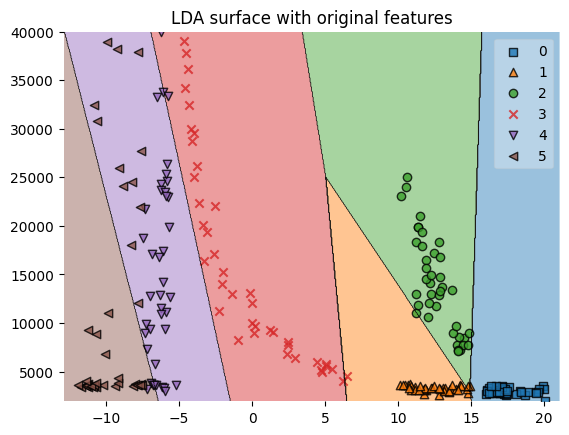

In [ ]:
feature_indexes = [3, 0]
sk_lda1 = LinearDiscriminantAnalysis(solver='eigen')
sk_lda1.fit(X1_train[:, feature_indexes], y1_train)
plt.title('LDA surface with original features')
plot_decision_regions(X=X1[:, feature_indexes], y=y1, clf=sk_lda1)

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Axes: title={'center': 'LDA surface with transformed features'}>

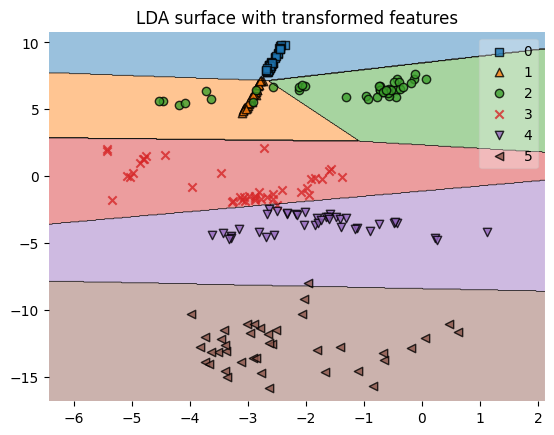

In [ ]:
feature_indexes = [3, 0]
sk_lda2 = LinearDiscriminantAnalysis(solver='eigen')
X1_lda = sk_lda2.fit(X1, y1).transform(X1)
X1_lda = X1_lda[:, feature_indexes]
X1_lda_train, X1_lda_test, y1_train, y1_test = train_test_split(X1_lda, y1, random_state=0)
sk_lda2.fit(X1_lda_train, y1_train)
plt.title('LDA surface with transformed features')
plot_decision_regions(X=X1_lda, y=y1, clf=sk_lda2)

### **Преимущества и недостатки LDA**

Преимущества:
- простой и эффективный метод для линейной классификации и понижения размерности;
- учитывает различия между классами и внутри классов;
- хорошо работает, когда классы имеют нормальное распределение и одинаковую ковариационную матрицу.

Недостатки:
- требуется достаточного количества данных для каждого класса, чтобы оценить матрицы разброса;
- чувствителен к выбросам и нарушению предположений о нормальности и гомоскедастичности;
- может быть неэффективным, когда число признаков сильно превышает число объектов.

### **Дополнительные источники**
Статья «Linear and Quadratic Discriminant Analysis: Tutorial», Benyamin Ghojogh, Mark Crowley.

Документация:
- [описание дискриминантного анализа](https://scikit-learn.org/stable/modules/lda_qda.html);
- [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html);
- [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html).

Видео: [один](https://www.youtube.com/watch?v=julEqA2ozcA), [два](https://www.youtube.com/watch?v=9SuIE_tGF-g), [три](https://www.youtube.com/watch?v=azXCzI57Yfc), [четыре](https://www.youtube.com/watch?v=C0u_v7vEDBY&t=799s).




